In [1]:
import os
import functools
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import cv2

import dataset_configs
import data_io
import u_net

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

tf.__version__

'2.0.0-alpha0'

# Set up

In [3]:
task = 'both_seg'
test_size = 0.2
random_state = 423

data_cfg = dataset_configs.get_dataset_config(task)
x_train_fnames, x_val_fnames, y_train_fnames, y_val_fnames = \
    data_io.get_data_filenames(**data_cfg, test_size=test_size, random_state=random_state)

num_train_data = len(x_train_fnames)
num_val_data = len(x_val_fnames)

print("Number of training samples: {}".format(num_train_data))
print("Number of validation samples: {}".format(num_val_data))

Number of training samples: 345
Number of validation samples: 87


In [ ]:
idx = np.random.choice(num_val_data)
print(os.path.basename(x_val_fnames[idx]))
print(os.path.basename(y_val_fnames[idx]))

In [16]:
4160/52/4

80.0

# Test the input pipeline

255.0
255.0
(1, 880, 1080, 3)
255.0
255.0
(1, 880, 1080, 3)
255.0
255.0
(1, 880, 1080, 3)


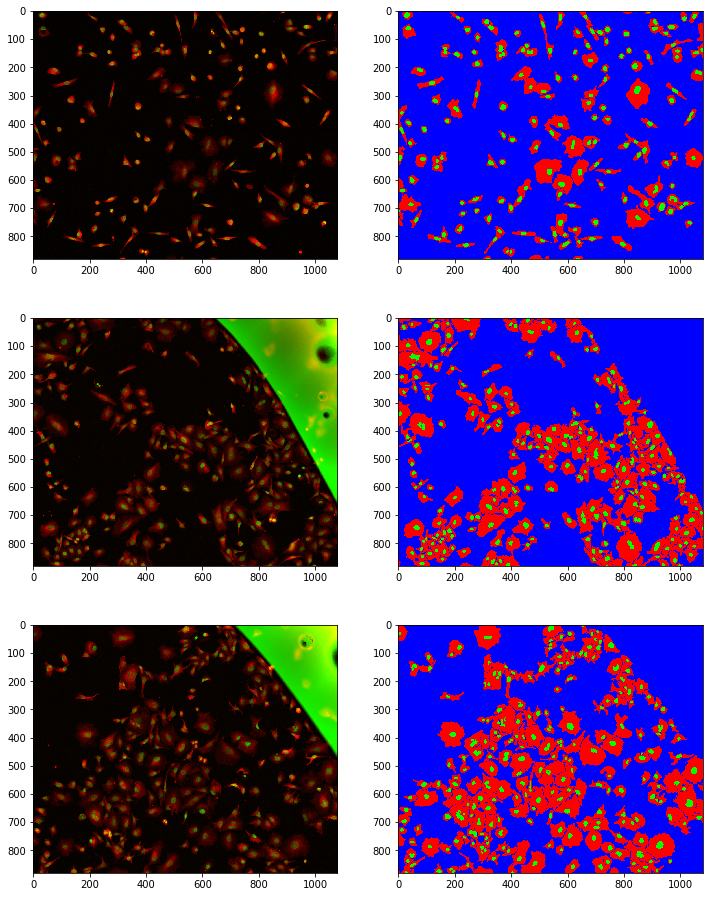

In [9]:
read_img_fn = functools.partial(data_io._get_image_from_path, channels=data_cfg['n_channels'], 
                                dtype=data_cfg['dtype'], crop_bd_width=data_cfg['crop_bd_width'])
tmp_ds = data_io.get_dataset(x_train_fnames, y_train_fnames, read_img_fn=read_img_fn)

plt.figure(figsize=(12,16))
for i, (img, mask) in enumerate(tmp_ds.shuffle(num_train_data).take(3)):
    print(img.numpy().max())
    print(mask.numpy().max())
    print(img.shape)
    plt.subplot(3,2,2*i+1)
    plt.imshow(img[0,:,:,:]/255.)
    plt.subplot(3,2,2*i+2)
    plt.imshow(mask[0,:,:,:]/255.)
plt.show()

# Configure training and validation datasets

In [12]:
read_img_fn = functools.partial(data_io._get_image_from_path, channels=data_cfg['n_channels'], 
                                dtype=data_cfg['dtype'], crop_bd_width=data_cfg['crop_bd_width'])

batch_size = 5

# training data
train_cfg = {
    'resize': None, 
    'scale': 1/255.,
    'crop_size': [512, 512],
    'to_flip': True
}
tr_preproc_fn = functools.partial(data_io._augment, **train_cfg)

# validation data
val_cfg = {
    'resize': None, 
    'scale': 1/255.,
    'crop_size': [512, 512]
}
val_preproc_fn = functools.partial(data_io._augment, **val_cfg)

train_ds = data_io.get_dataset(x_train_fnames, y_train_fnames, read_img_fn=read_img_fn,
                               preproc_fn=tr_preproc_fn, shuffle=True, batch_size=batch_size)
val_ds = data_io.get_dataset(x_val_fnames, y_val_fnames, read_img_fn=read_img_fn, 
                             preproc_fn=val_preproc_fn, shuffle=False, batch_size=batch_size)

In [ ]:
plt.figure(figsize=(12,16))
for i, (img, mask) in enumerate(val_ds.take(3)):
    print(img.shape)

    plt.subplot(3,3,3*i+1)
    plt.imshow(img[0,:,:,:])
    
    plt.subplot(3,3,3*i+2)
    plt.imshow(mask[0,:,:,:])
    
#     plt.subplot(3,3,3*i+3)
#     plt.imshow(mask[0,:,:,1])

# Customized loss

In [ ]:
for img, mask in val_ds.shuffle(num_val_data).take(1):
    idx = 0
    
    w_cfg = {
        'nuc_ch': 1,
        'cell_ch': 0,
        'w0': 10,
        'sigma': 3
    }
    
    y_pred = model(img)
    
    loss, cb, nuc_dw, cell_dw = u_net.weighted_cce_loss(mask, y_pred, **w_cfg)
    print(tf.reduce_max(cb, axis=(1,2)))
    
    print(loss.shape)
    print(cb.shape)
    print(nuc_dw.shape)
    print(cell_dw.shape)
    
    L = loss[idx].numpy()
    CB = cb[idx].numpy()
    b = np.zeros_like(mask[idx,...,0])
    NW = nuc_dw[idx].numpy()
    CW = cell_dw[idx].numpy()
    
#     CB = CB / CB.max()
#     NW = NW / np.median(NW)
#     CW = CW / np.median(CW)
    
    plt.figure(figsize=(16,16))
    plt.subplot(2,2,1)
    plt.imshow(np.dstack([NW/NW.max(), mask[idx,...,w_cfg['nuc_ch']], b]))
    
    plt.subplot(2,2,2)
    plt.imshow(np.dstack([CW/CW.max(), mask[idx,...,w_cfg['cell_ch']], b]))
    
    plt.subplot(2,2,3)
    plt.imshow(np.dstack([L, mask[idx,...,w_cfg['cell_ch']], b]))
    
    print([CB.min(), CB.mean(), CB.max()])
    print([NW.min(), NW.mean(), NW.max()])
    print([CW.min(), CW.mean(), CW.max()])
    print([L.min(), L.mean(), L.max()])
    
#     plt.subplot(2,2,3)
#     plt.hist(NW, bins='auto')
    
#     plt.subplot(2,2,4)
#     plt.hist(CW, bins='auto')
    

In [ ]:
for (img, mask) in val_ds.shuffle(30).take(1):
    print(mask.dtype)
#     L = u_net.weighted_loss(mask, mask)
    M = mask[0,:,:,0]
    wc = u_net.balancing_weight_tf(M)
    dw = u_net.distance_weight(M.numpy(), w0=10, sigma=5.0)
    
    
    plt.figure(figsize=(12,16))
    b = np.zeros_like(M)
    plt.imshow(np.dstack([dw, M, b]))
#     plt.imshow(dw)
    
#     plt.subplot(1,3,1)
#     plt.imshow(img[0,:,:,0])

#     plt.subplot(1,3,2)
#     plt.imshow(M)

#     plt.subplot(1,3,3)
#     plt.imshow(dw)
    
#     print(L.shape)
    print((wc.numpy().min(), wc.numpy().max()))
    print((dw.min(), dw.max()))
    
#     plt.figure(figsize=(12,16))
    
#     for i, w in enumerate(L):
#         if i>2:
#             break
            
#         plt.subplot(3,3,3*i+1)
#         plt.imshow(img[i,:,:,0])

#         plt.subplot(3,3,3*i+2)
#         plt.imshow(mask[i,:,:,0])

#         plt.subplot(3,3,3*i+3)
#         plt.imshow(w)
#         print((w.numpy().min(), w.numpy().max()))
        


# Build the model

In [13]:
num_filters_list = [32, 64, 128, 256, 512]
n_classes = 3

w_cfg = {
    'nuc_ch': 1,
    'cell_ch': 0,
    'w0': 10,
    'sigma': 3
}

model = u_net.Unet(num_filters_list, n_classes=n_classes, dynamic=True)

# loss_fn = functools.partial(u_net.weighted_loss, w0=w0, sigma=sigma)
loss_fn = functools.partial(u_net.weighted_cce_loss, **w_cfg)

model.compile(optimizer='adam', loss=loss_fn)
# model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=[u_net.dice_loss])

# plt.figure(figsize=(12,16))
# for i, (img, mask) in enumerate(train_ds.take(1)):
#     y_pred = model(img)
    
#     plt.subplot(1,3,1)
#     plt.imshow(img[0,:,:,0])
#     plt.subplot(1,3,2)
#     plt.imshow(mask[0,:,:,0])
#     plt.subplot(1,3,3)
#     plt.imshow(y_pred[0,:,:,0])
# plt.show()

In [ ]:
y = model(tf.random.uniform([1, 512, 512, 3]))
print(y.shape)

## Train the model

In [14]:
root_path = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation'
model_tag = 'both_weighted_cce_2_'

timestamp = '{}'.format(datetime.datetime.now()).split('.')[0].replace(':','_').replace(' ','_')
foler_name = model_tag + timestamp

# model weights
weights_path = os.path.join(root_path, 'models', foler_name, 'weights-{epoch:04d}.ckpt')
weights_dir = os.path.dirname(weights_path)
if not os.path.isdir(weights_dir):
    os.makedirs(weights_dir, exist_ok=True)
cp = tf.keras.callbacks.ModelCheckpoint(filepath=weights_path, monitor='val_loss', 
                                        save_best_only=True, save_weights_only=True, verbose=1)
# tensorboard
log_dir = os.path.join(root_path, 'logs', foler_name)
if not os.path.isdir(log_dir):
    os.makedirs(log_dir, exist_ok=True)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [15]:
history = model.fit(train_ds, epochs=50, 
                    steps_per_epoch=int(np.ceil(num_train_data / batch_size)),
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_data / batch_size)),
                    callbacks=[cp, tb])

W0423 10:18:02.683222 139709404784384 callbacks.py:1218] TensorBoard Callback will ignore `write_graph=True`when `Model.run_eagerly=True`.`


Epoch 1/50
 4/69 [>.............................] - ETA: 6:56 - loss: 0.1581

KeyboardInterrupt: 

In [ ]:
import importlib
importlib.reload(u_net)

In [ ]:
for (x,y) in train_ds.take(1):
    u_net.bce_dice_loss(y,y)

In [ ]:
print(tf.data.experimental.AUTOTUNE)

### Plot training process

In [ ]:
tr_process = pd.DataFrame.from_dict(history.history)
tr_process['epoch'] = np.array(range(1, tr_process.shape[0]+1))

tr_process.plot(x='epoch', y=['loss', 'val_loss'])
# tr_process.plot(x='epoch', y=['dice_loss', 'val_dice_loss'])

### Or load the trained weights

In [ ]:
model_dir = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/models/nucleus_weighted_bce22019-04-16_07_38_00'
latest = tf.train.latest_checkpoint(model_dir)
print(latest)
model.load_weights(latest)

In [ ]:
model.evaluate(val_ds, steps=int(np.ceil(num_val_data / batch_size)))

# Visualize performance

In [ ]:
def overlay_mask(img, mask, mask_pred):
    """green: true, red: predicted"""
    I = np.uint8(img.numpy()*255.)
    I = cv2.cvtColor(I,cv2.COLOR_GRAY2RGB)
    
    M = np.uint8(mask.numpy()*255.)
    M_pred = np.uint8((mask_pred.numpy()>0.5) * 255.)
    
    im, contours, _ = cv2.findContours(M.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im_pred, contours_pred, _ = cv2.findContours(M_pred.copy(), 
                                                cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    I1 = cv2.drawContours(I.copy(), contours, -1, (0,255,0), 1)
    I2 = cv2.drawContours(I.copy(), contours_pred, -1, (255,0,0), 1)
    I[:,:,1] = I1[:,:,1]
    I[:,:,0] = I2[:,:,0]
    
    return I

In [ ]:
def overlay_mask(I, M, M_pred, true_color=(0,255,0), pred_color=(255,0,0)):
    """I, M, M_pred are uint8 numpy arrays
    """
    if I.shape[-1] == 1:
        I = cv2.cvtColor(I,cv2.COLOR_GRAY2RGB)
    
    im, contours, _ = cv2.findContours(M.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im_pred, contours_pred, _ = cv2.findContours(M_pred.copy(), 
                                                 cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    Z = np.zeros_like(I)
    if true_color is None:
        I1 = np.zeros_like(I)
    else:
        I1 = cv2.drawContours(Z.copy(), contours, -1, true_color, 1)
        
    I2 = cv2.drawContours(Z.copy(), contours_pred, -1, pred_color, 1)
    
    I = np.uint8(np.clip(np.float32(I) + np.float32(I1) + np.float32(I2), 0, 255))
    
    return I

In [ ]:
idx_to_plot = np.random.choice(num_val_data, 3)
result_folder = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/results'
nuc_idx = 1
cell_idx = 0

if not os.path.isdir(result_folder):
    os.makedirs(result_folder)

# plt.figure(figsize=(12,16))

for i, (img, mask) in enumerate(val_ds):
    if i in idx_to_plot:
        y_pred = model(img)        
        for j in range(4):
            if task == 'both_seg':
                I = np.uint8(img[j].numpy()*255.)
                M = np.uint8(mask[j].numpy()*255.) 
                M_pred = np.uint8((y_pred[j].numpy() > 0.5) *255.)
                
                # overlay nucleus segmentation
                I = overlay_mask(I, M[:,:,nuc_idx], M_pred[:,:,nuc_idx], 
                                 true_color=None, pred_color=(0,255,255))
                # overlay cell segmentation
                I = overlay_mask(I, M[:,:,cell_idx], M_pred[:,:,cell_idx], 
                                 true_color=None, pred_color=(255,0,255))
                
            else:
                I = overlay_mask(img[j,:,:,0], mask[j,:,:,0], y_pred[j,:,:,0])
            
            fname = os.path.join(result_folder, '{}_{}.png'.format(i,j))
            cv2.imwrite(fname, cv2.cvtColor(I, cv2.COLOR_RGB2BGR))
            
#             plt.subplot(2,2,j+1)
#             plt.imshow(I)
            
    if i > max(idx_to_plot):
        break

In [ ]:
# %matplotlib notebook
# plt.figure(figsize=(16, 16))
for img, mask in val_ds.shuffle(num_val_data).take(1):
    idx = 0
    y_pred = model(img)
    
    plt.subplot(1,3,1)
    plt.imshow(img[idx])
    
    plt.subplot(1,3,2)
    plt.imshow(y_pred[idx,:,:,0], cmap='gray')
    
    plt.subplot(1,3,3)
    plt.imshow(y_pred[idx,:,:,1], cmap='gray')
    
#     print(mask[idx].numpy().sum(axis=(0,1)))
#     print(mask[idx].numpy().sum())
    print(y_pred[idx].numpy().max())

In [ ]:
import importlib
importlib.reload(data_io)

In [ ]:
%matplotlib notebook
# plt.figure(figsize=(16, 16))

idx = np.random.choice(num_val_data)
img = cv2.imread(x_val_fnames[idx]) 
mask = cv2.imread(y_val_fnames[idx])

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) / 255.

img2 = tf.image.decode_png(tf.io.read_file(x_val_fnames[idx]), channels=3, dtype=tf.uint16)
img2 = tf.cast(img2, tf.float32) / 255.
# img2 = tf.image.convert_image_dtype(img2, tf.uint8, saturate=True)
img2 = img2.numpy()

print(img2.dtype, img2.min(), img2.max())

plt.figure
plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(img2)

# print(img.shape, mask.shape)
# print(img.dtype, img.min(), img.max())
# print(mask.dtype, mask.min(), mask.max())
# 

# y_pred = model(img)

# plt.subplot(1,3,1)
# plt.imshow(img[idx])

# plt.subplot(1,3,2)
# plt.imshow(y_pred[idx,:,:,0], cmap='gray')

# plt.subplot(1,3,3)
# plt.imshow(y_pred[idx,:,:,1], cmap='gray')
    
#     print(mask[idx].numpy().sum(axis=(0,1)))
#     print(mask[idx].numpy().sum())
#     print(y_pred[idx].numpy().max())

In [ ]:
for img, mask in val_ds.shuffle(num_val_data).take(1):
    idx = 0
    y_pred = model(img)
    N = tf.reduce_sum(mask, axis=(1,2))
    W = tf.expand_dims(1 / N, axis=1)
    W = tf.expand_dims(W, axis=2)
    weight = mask * W / mask.shape[-1]
    print(tf.reduce_sum(weight, axis=(1,2,3)))
#     plt.imshow(weight[0] / weight[0].numpy().max())
#     print(tf.unique(tf.reshape(weight[0], [-1])))

In [ ]:
%matplotlib notebook
fname = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/data/plate_2017017086_ki67/images/CH_171219_Vh31_Goldilocks_plate_2017017086_ki67_B8_0001-2.png'

img = tf.image.decode_image(tf.io.read_file(fname), channels=3, dtype=tf.uint8)
# img = tf.cast(img, tf.float32) / 4095.
# img = tf.image.convert_image_dtype(img, tf.uint8, saturate=True)
print(img.shape)
img = img.numpy()
print(img.min(), img.max())

plt.figure
plt.imshow(img)

